# Analysis of Divvy Bike traffic with scikit-learn

Chicago's blue Divvy bikes have become an instantly recognizable feature of the urban landscape. Divvy--which surpassed 10 million rides early last year--has become an indespensible travel option for commuters, errand-runners, and tourists alike.

Since Divvy is a dock-based system (the bicycles must be taken out and returned to fixed docking stations throughout the city), its maintainers must make informed decisions about where to place (or move) stations in order to satisfy demand and deliver convenience and safety for their users.

Additionally, Divvy's maintainers need to make informed decisions about how to keep the number of available bikes (and docks) balanced throughout the day.

Inspired by [Jake VanderPlas's analysis of Seattle's commuting habits](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/) based on daily bike counts on the Fremont bridge, I decided to take a look at Divvy's ridership data to see if Python could "learn" something about the temporal usage patterns of Divvy stations.

## The Data
### Divvy trips
The City of Chicago makes Divvy trip data available through its website [data.cityofchicago.org]. Each record is a single trip, with its start station, end station, start time, end time, and bicycle ID.

### Geospatial data
Additionally, the city makes available the locations of all the Divvy stations throughout the city. The GIS shapefiles containing the boundaries of the official Chicago Community Areas, and the CTA rail lines are also available through the city's website.

In [1]:
# Numerical packages and miscellaneous
import sodapy
from os.path import exists
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Plotting and geometry packages
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, LineString, MultiLineString
from shapely.ops import linemerge
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

# GIS and spatial projection packages
from shapefile import Reader
from pyproj import Proj, transform
import pycrs

from IPython.display import display

%matplotlib inline
sns.set()

# Chicago Open Data Portal API
data_url = 'data.cityofchicago.org'
app_token = '6xUrAQkGuIctuyUrTEdLZZFRY'
d_trips = 'fg6s-gzvg'
d_stats = 'aavc-b2wj'

api = sodapy.Socrata(data_url, app_token)

## Data acquisition and processing

I accessed the trips data through Chicago's Socrata Open Data API. I collected the aggregated hourly trip counts to and from each station for all trips made in 2017.

In [2]:
def get_hourly_counts(stat_id, dirxn, days):
    'Get number of trips per hour (0-23) to or from a station'
    
    success = False
    n_tries = 0
    
    while not success and n_tries < 10:
        try:
            # Query Divvy data through Chicago Open Data Portal
            r = api.get(d_trips, select='count(trip_id), date_extract_hh({0:s}_time) as hour'.format(dirxn[1]),
                        group='date_extract_hh({0:s}_time)'.format(dirxn[1]),
                        where=(("{1:s}_station_id='{0:d}' " +
                                "and {2:s}_time between '2017-01-01' and '2017-12-31' " +
                                "and date_extract_dow({2:s}_time) in ({3:s})")
                               .format(stat_id, dirxn[0], dirxn[1],
                                        ','.join(str(d) for d in days))))

            # Returns a table with aggregated hourly counts, 1 row per hour.
            # Convert to one column per hour, index = station_id
            d = pd.DataFrame.from_records(r).astype(int).set_index('hour').sort_index()
            dT = pd.DataFrame(d.transpose().to_dict())
            dT.index = [stat_id]
            return dT

        except Exception as e:
            print '   ### ERROR ON STATION {0:d}'.format(stat_id)
            n_tries = n_tries + 1

    print '   ### FAILED ON STATION {0:d}'.format(stat_id)
    raise e

In [3]:
# Alternative way to get hourly station counts WITHOUT making one API call per station.
# Due to throttling limitations, it is only possible to get about 2 months of data at a time.

if False:
    dirxn = ('to', 'stop')
    days = [1, 2, 3, 4, 5]

    r = api.get(d_trips, select='{0:s}_station_id, count(trip_id), date_extract_hh({1:s}_time) as hour'.format(dirxn[0], dirxn[1]),
                group='{0:s}_station_id, date_extract_hh({1:s}_time)'.format(dirxn[0], dirxn[1]),
                where=(("{2:s}_time between '2017-01-01' and '2017-1-31' " +
                        "and date_extract_dow({2:s}_time) in ({3:s})")
                       .format(stat_id, dirxn[0], dirxn[1],
                                ','.join(str(d) for d in days))))

    df = pd.DataFrame.from_records(r)

    df.pivot(index='to_station_id', columns='hour', values='count_trip_id')

In [4]:
# Load station information with aggregated ride counts
print 'LOADING STATION INFORMATION WITH TOTAL RIDE COUNTS'
df_stats = pd.read_csv('stations_trip_counts.csv', index_col=0)
df_stats[['num_trips_to', 'num_trips_from']] = df_stats[['num_trips_to', 'num_trips_from']].astype(float)

df_stats['num_trips'] = df_stats['num_trips_to'] + df_stats['num_trips_from']

# Weekday to-station counts
days_to_count = [1, 2, 3, 4, 5]  # Monday-Friday

if exists('stations_hourly_wd_to_counts.csv'):
    print 'LOADING WEEKDAY TO-COUNTS'
    df_wd_to_counts = pd.read_csv('stations_hourly_wd_to_counts.csv', index_col=0)
else:
    df_wd_to_counts = pd.DataFrame()
    dirxn = ('to', 'stop')

    for stat_id in [2, 3, 4]:
        print 'GETTING WEEKDAY TO-COUNTS FOR STATION {:d}'.format(stat_id)
        row = get_hourly_counts(stat_id, dirxn, days_to_count)
        df_wd_to_counts = df_wd_to_counts.append(row)

# Weekday from-station counts
if exists('stations_hourly_wd_from_counts.csv'):
    print 'LOADING WEEKDAY FROM-COUNTS'
    df_wd_from_counts = pd.read_csv('stations_hourly_wd_from_counts.csv', index_col=0)
else:
    df_wd_from_counts = pd.DataFrame()
    dirxn = ('from', 'start')

    for stat_id in [2, 3, 4]:
        print 'GETTING WEEKDAY TO-COUNTS FOR STATION {:d}'.format(stat_id)
        row = get_hourly_counts(stat_id, dirxn, days_to_count)
        df_wd_from_counts = df_wd_from_counts.append(row)
        
        
# Total hourly ride counts (to and from) station
df_wd_counts = df_wd_to_counts + df_wd_from_counts

# Total daily weekday ride counts (to and from) station
trips_tot = df_wd_counts.sum(axis=1)

LOADING STATION INFORMATION WITH TOTAL RIDE COUNTS
LOADING WEEKDAY TO-COUNTS
LOADING WEEKDAY FROM-COUNTS


In [5]:
df_wd_counts.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2,119.0,51.0,18.0,4.0,3.0,40.0,123.0,316.0,550.0,538.0,...,1436.0,1522.0,1576.0,1701.0,1376.0,1017.0,725.0,580.0,327.0,217.0
3,91.0,46.0,9.0,8.0,6.0,19.0,104.0,603.0,973.0,1313.0,...,3838.0,3921.0,3795.0,2453.0,1764.0,1202.0,784.0,612.0,523.0,222.0
4,93.0,12.0,11.0,4.0,5.0,35.0,317.0,518.0,847.0,919.0,...,2084.0,1956.0,2270.0,2943.0,2372.0,1794.0,953.0,431.0,234.0,154.0
5,89.0,22.0,20.0,10.0,10.0,52.0,311.0,443.0,956.0,713.0,...,475.0,590.0,945.0,1455.0,1024.0,727.0,566.0,432.0,278.0,172.0
6,109.0,45.0,13.0,7.0,4.0,42.0,172.0,473.0,770.0,797.0,...,2027.0,2173.0,2320.0,2680.0,1871.0,1326.0,891.0,642.0,498.0,281.0


## The Analysis

The tables of hourly counts TO and FROM each station are concatenated into a single table with (n_stations) rows and 48 columns (24 hours per day, TO and FROM). Then each row is normalized by the total trips starting or ending at each station. This is important to ensure that our clustering routine won't be confounded by the most obvious differentiator in the data: total ridership.

For visualization purposes, the 48-dimensional "hourly counts" vectors are projected down to 2-dimensions using Principal Component Analysis. Unlike the Seattle bike counts, the stations do not cluster as obviously because we are only looking at weekly ridership data and excluding weekends.

Next, the stations are assigned to clusters using the k-means algorithm. The clusters are ranked according to the mean trips per station in each cluster (so as to ensure a unique mapping of cluster ID to clusters). Increasing the number of clusters above 2 results in further subdivision amongst one of the clusters, rather than identification of a qualitatively different group.

(464, 48)


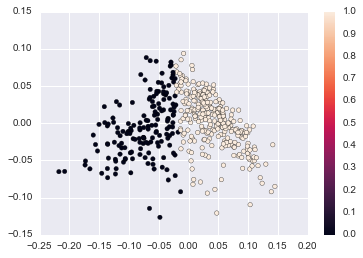

In [6]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Weekday trip counts from stations with more than 500 annual trips
filt = trips_tot > 500
X = pd.concat([df_wd_to_counts[filt], df_wd_from_counts[filt]], axis=1)
print X.shape

# Normalize ROWS by the total trips (ending and starting) at each station
X_norm = X.div(X.sum(axis=1), axis=0)

# 
# pca_clust = PCA(0.9)
# y_pc_clust = pca_clust.fit_transform(X_norm)

# Project 48-dimensional rows onto 2-dimensions for plotting purposes
pca_vis = PCA(n_components=2)
y_pc_vis = pca_vis.fit_transform(X_norm)

# 
n_clusters = 2
km = KMeans(n_clusters=n_clusters)
clust = km.fit_predict(X_norm)

# The k-means solution is NON-UNIQUE
# Assign stations to clusters ranked by mean total rides per cluster
df_stats['cluster'] = 0
df_stats.at[filt, 'cluster'] = pd.Series(clust).values + 1

cluster_order = df_stats[['cluster', 'num_trips']].groupby(by='cluster').mean().sort_values('num_trips').index
df_stats['cluster'] = df_stats['cluster'].apply(lambda x: cluster_order[x])

plt.scatter(y_pc_vis[:, 0], y_pc_vis[:, 1], c=clust)
plt.colorbar()
plt.show()

## Location, location, location

Unlike the Seattle analysis (in which location was fixed and time was sampled), the patterns of Divvy station usage may depend on their location in the city.

Indeed, one of clusters includes most of the stations in the downtown central business district, and along the most heavily-used "L" lines.

In [8]:
# Get bounding box for Chicago

s_lat = 41.735  # 87th street
n_lat = 42.069  # Wilmette
w_lon = -87.816  # Forest Park
e_lon = -87.524  # State line

map = Basemap(projection='tmerc', ellps='WGS84',
              lon_0=0.5*(w_lon + e_lon),
              lat_0=0.5*(s_lat + n_lat),
              llcrnrlon=w_lon, llcrnrlat=s_lat,
              urcrnrlon=e_lon, urcrnrlat=n_lat,
              resolution='i', suppress_ticks=True)

# Read Chicago Community Areas shapefile
map.readshapefile('chi_ca/chi_ca', name='chicago',
                  drawbounds=False, color='none', zorder=2);

# Convert station lat/lon to points on the map
df_stats['map_point'] = [Point(map(x, y)) for x, y in zip(df_stats['longitude'], df_stats['latitude'])]

# Read neighborhoods shapefile
hoods = pd.DataFrame({'poly': [Polygon(xy) for xy in map.chicago],
                      'name': [n['community'] for n in map.chicago_info]})

# Create a patch for each neighborhood
hoods['patch'] = hoods['poly']\
    .map(lambda x: PolygonPatch(x, fc='#AAAAAA',
                                ec='#000000', lw=.25, alpha=.9,
                                zorder=1))

# Read CTA L lines shapefile
proj4str = pycrs.loader.from_file('chi_CTA/CTA_RailLines.prj').to_proj4()

# CTA L lines shapefile is given in projected coordinates. Convert back to lat/lon
inProj = Proj(proj4str, preserve_units=True)
outProj = Proj(init='epsg:4326')

cta = Reader('chi_CTA/CTA_RailLines.shp')
l_lines = pd.DataFrame({'line': [r[5] for r in cta.records()],
                        'LineString': [LineString(zip(*transform(inProj, outProj, zip(*c.points)[0], zip(*c.points)[1])))
                                       for c in cta.shapes()]})

blue = linemerge(MultiLineString(l_lines[l_lines['line'] == 'BL']['LineString'].tolist()))
red = linemerge(MultiLineString(l_lines[l_lines['line'] == 'RD']['LineString'].tolist()))
brn = linemerge(MultiLineString(l_lines[l_lines['line'] == 'BR']['LineString'].tolist()[4:19]))

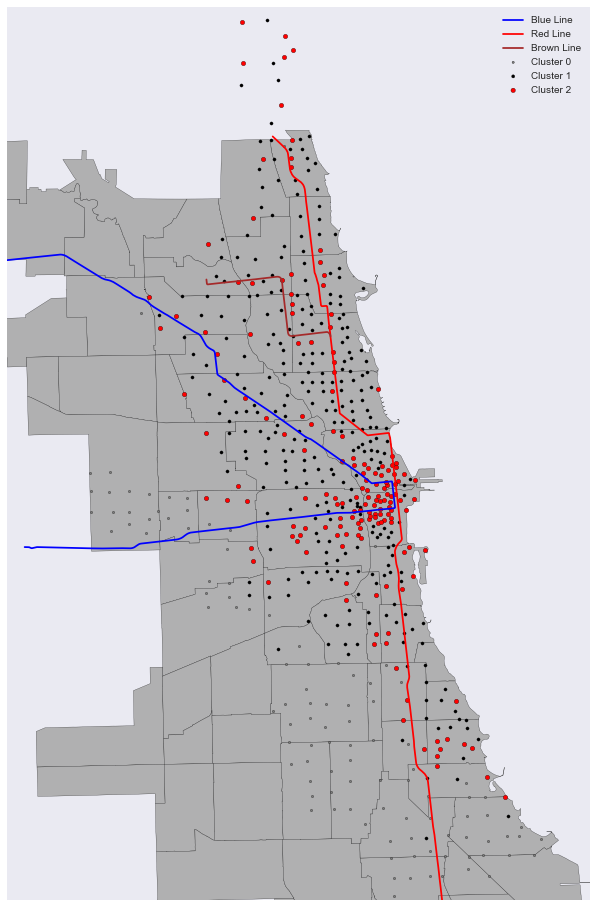

In [9]:
fig, ax = plt.subplots(figsize=(12, 16))

sz = [5, 10, 20]
col = ['gray', 'black', 'r']

for i in range(n_clusters + 1):
    map.scatter([p.x for p in df_stats[df_stats['cluster'] == i]['map_point']],
                [p.y for p in df_stats[df_stats['cluster'] == i]['map_point']],
                c=col[i], s=sz[i], zorder=2, label='Cluster {:d}'.format(i));

# Draw neighborhood boundaries
ax.add_collection(PatchCollection(hoods['patch'].values, match_original=True))

# Plot a rail line
blue_x, blue_y = blue.xy
blue_mx, blue_my = map(np.array(blue_x) + 8.21888, np.array(blue_y) + 0.25)
map.plot(blue_mx, blue_my, c='b', label='Blue Line')

red_x, red_y = red.xy
red_mx, red_my = map(np.array(red_x) + 8.21888, np.array(red_y) + 0.25)
map.plot(red_mx, red_my, c='r', label='Red Line')

brn_x, brn_y = brn.xy
brn_mx, brn_my = map(np.array(brn_x) + 8.21888, np.array(brn_y) + 0.25)
map.plot(brn_mx, brn_my, c='brown', label='Brown Line')

plt.legend(loc='upper right')
plt.show()

## Averaged hourly counts

How do the temporal distributions of trips differ between clusters?

Cluster 1 seems to be dominated by stations that people commute FROM in the morning and TO in the evening, while Cluster 2 is dominated by stations that people commute TO in the morning and FROM in the evening. Although Cluster 2 stations have higher AVERAGE ridership, the bulk of the rides in the entire system are accounted for in Cluster 1.

Cluster 2 stations are concentrated around rail lines and places of employment. These stations need more docks to deal with the high concentration of users. Since there tend to be a few concentrated Cluster 1 stations, they can be easily serviced by the Divvy re-distribution vans.

Cluster 1 stations, on the other hand, are distributed throughout the neighborhoods. Although the mean demand per station is smaller, they are much more difficult to reach in a timely fashion during the critical rush periods. These stations should be well-stocked in the morning, and the re-distribution vans can make necessary adjustments at leisure late at night.

Note: "Cluster 0" represents stations with less than 500 trips.

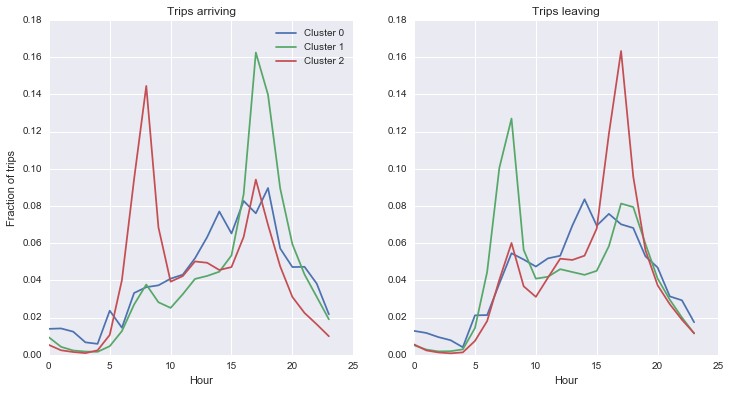

In [10]:
df_wd_to_counts_norm = df_wd_to_counts.div(df_wd_to_counts.sum(axis=1), axis=0)
df_wd_from_counts_norm = df_wd_from_counts.div(df_wd_from_counts.sum(axis=1), axis=0)

fix, ax = plt.subplots(ncols=2, figsize=(12, 6))

for i in range(n_clusters+1):
    ax[0].plot(df_wd_to_counts_norm[df_stats['cluster'] == i].mean(), label='Cluster {:d}'.format(i))
    ax[1].plot(df_wd_from_counts_norm[df_stats['cluster'] == i].mean())
    
ax[0].set_title('Trips arriving')
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Fraction of trips')
ax[0].legend()

ax[1].set_title('Trips leaving')
ax[1].set_xlabel('Hour')

plt.show()